**Cohortes Avanzados**

In [ ]:
%run './analisis-calidad-datos-y-outliers.ipynb'

**1. Estacionalidad:**
- Cohorte Mensual: Análisis mensual de volúmenes de compra por región para identificar patrones estacionales.
- Comparación Año a Año: Comparar volúmenes y precios promedio año a año para identificar temporadas de alta demanda.
- Días Festivos y Temporadas de Vacaciones: Crear cohortes basados en semanas festivas y periodos de vacaciones para analizar cambios en compras.

In [ ]:
# Crear cohortes menual usando AveragePrice, Total Volume y Date.
cor1 = df.groupby(pd.Grouper(key='Date', freq='M')).agg(
    avg_price=('AveragePrice', 'mean'),
    total_volume=('Total Volume', 'sum')
).reset_index()

# Visualización
fig, ax1 = plt.subplots(figsize=(14, 7))

# Gráfico de líneas para el volumen total
ax1.plot(cor1['Date'], cor1['total_volume'], marker='s', label='Total Volume', linestyle='--', linewidth=2, color='green')
ax1.set_xlabel('Fecha (Trimestre)')
ax1.set_ylabel('Total Volume', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Crear un segundo eje y para el promedio de precio
ax2 = ax1.twinx()
ax2.plot(cor1['Date'], cor1['avg_price'], marker='o', label='Average Price', linestyle='-', linewidth=2, color='blue')
ax2.set_ylabel('Average Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Evolución Trimestral de Promedio de Precio y Volumen Total')
fig.tight_layout()
plt.grid(True)
plt.show()

In [5]:
df_avocado_hotels

,Date,AveragePrice,Total Volume,4046,4225,4770,type,year,region,location
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,conventional,2015,Albany,newyork
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,conventional,2015,Albany,newyork
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,conventional,2015,Albany,newyork
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,conventional,2015,Albany,newyork
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,conventional,2015,Albany,newyork
...,...,...,...,...,...,...,...,...,...,...
18112,2018-02-04,1.34,28070.07,13610.05,12257.81,0.00,organic,2018,SanFrancisco,california
18113,2018-01-28,2.27,20325.75,9368.06,8808.80,0.00,organic,2018,SanFrancisco,california
18114,2018-01-21,1.36,27919.45,13037.67,11998.44,0.00,organic,2018,SanFrancisco,california
18115,2018-01-14,1.32,37347.89,19301.15,14957.23,0.00,organic,2018,SanFrancisco,california


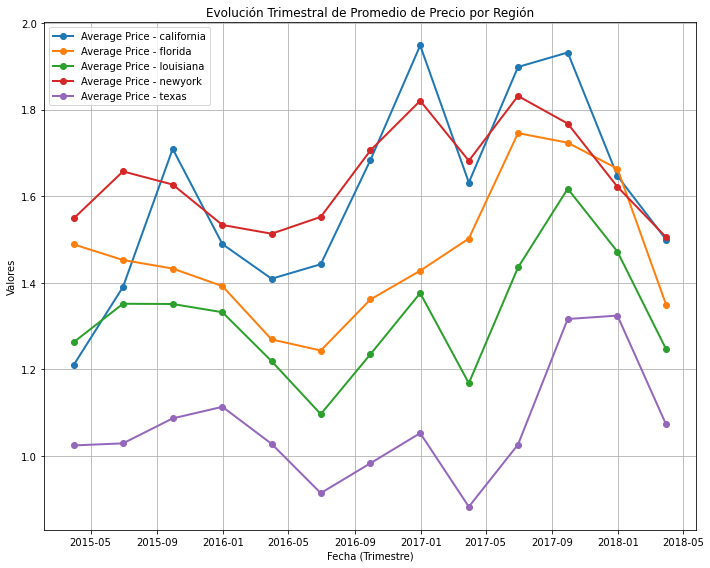

In [ ]:
df_avocado_hotels['Date'] = pd.to_datetime(df_avocado_hotels['Date'])

# Agrupar los datos por location y trimestre y calcular el promedio de 'AveragePrice' y la suma de 'Total Volume'
cor2 = df_avocado_hotels.groupby([pd.Grouper(key='Date', freq='Q'), 'location']).agg(
    avg_price=('AveragePrice', 'mean'),
    total_volume=('Total Volume', 'sum')
).reset_index()

# Visualización de la evolución de las cohortes por región
plt.figure(figsize=(10, 8))

# Gráfico de líneas para comparar las regiones
for region in cor2['location'].unique():
    region_data = cor2[cor2['location'] == region]
    plt.plot(region_data['Date'], region_data['avg_price'], marker='o', label=f'Average Price - {region}', linewidth=2)

plt.title('Evolución Trimestral de Promedio de Precio de compra por Región')
plt.xlabel('Fecha (Trimestre)')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**2. Exceso de Compras (Desperdicios o Fechas Especiales):**
- Compras Atípicas: Detectar semanas con volúmenes significativamente superiores a la media para investigar posibles desperdicios.
- Eventos Especiales: Identificar picos de compras asociados con eventos conocidos o temporadas de promociones de hoteles.
- Cohorte de Variabilidad de Precios: Analizar semanas con cambios bruscos en precios para correlacionarlos con posibles excesos de compra.

**3. Tipos de Aguacates (Orgánico vs. Convencional):**
- Segmentación por Tipo de Aguacate: Crear cohortes de compras separadas por type (orgánico vs. convencional) y analizar diferencias en precios y volúmenes por temporada.
- Demanda Relativa: Comparar la proporción de compras de orgánico vs. convencional a lo largo del año.

**4. Proveedores y Seguridad de Consumo:**
- Ranking de Proveedores: Crear un ranking de regiones/productores según precios promedio y estabilidad de oferta a lo largo del año.
- Análisis de Vacíos de Oferta: Identificar periodos de baja oferta de ciertos productores y buscar productores alternativos con precios competitivos en esas fechas.